In [236]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import statsmodels.api as sm
import pickle
import numpy as np
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from numpy.linalg import norm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier

df = pd.read_csv('data/admission_data.csv')


In [11]:
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


# Unique Model for all Unis

In [179]:
X = df.drop('Chance of Admit ', axis=1)
Y = df['Chance of Admit ']

<AxesSubplot:>

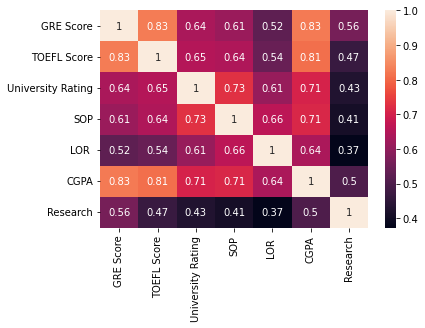

In [180]:
sns.heatmap (X.corr(), annot=True)

In [250]:
model = sm.OLS(Y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       Chance of Admit    R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     324.4
Date:                Mon, 04 Jul 2022   Prob (F-statistic):          8.21e-180
Time:                        15:50:38   Log-Likelihood:                 701.38
No. Observations:                 500   AIC:                            -1387.
Df Residuals:                     492   BIC:                            -1353.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.2757      0.10

# Features are correlated and therefore linear regression is not reliable
## We will use projection models like PCR/PLS instead: they are interpretable, simple and handle correlated features

C:\git\gradpredictor\gradpredictor\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\git\gradpredictor\gradpredictor\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


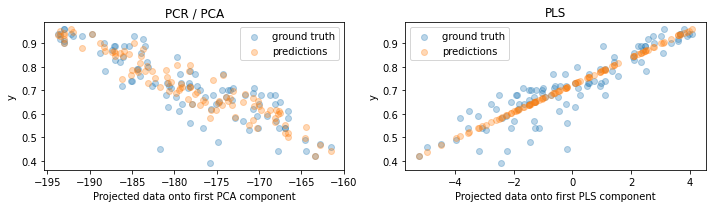

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size = 0.2, random_state=42)

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)


fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(X_test), pcr.predict(X_test), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_test), pls.predict(X_test), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="PLS")
axes[1].legend()
plt.tight_layout()
plt.show()

In [183]:
print(f"PCR r-squared {pcr.score(X_test, y_test):.3f}")
print(f"PLS r-squared {pls.score(X_test, y_test):.3f}")

PCR r-squared 0.798
PLS r-squared 0.801


In [184]:
n = 3
pcr_2 = make_pipeline(StandardScaler(),PCA(n_components=n), LinearRegression())
pcr_2.fit(X_train.values, y_train.values)
pls_2 = PLSRegression(n_components=n)
pls_2.fit(X_train.values, y_train.values)
print(f"PCR r-squared with {n} components {pcr_2.score(X_test.values, y_test.values):.3f}")
print(f"PLS r-squared with {n} components {pls_2.score(X_test.values, y_test.values):.3f}")

PCR r-squared with 3 components 0.797
PLS r-squared with 3 components 0.810


#### CGPA is the most powerful predictor (sad...)

In [185]:
coeffs = pd.DataFrame(pls_2.coef_.transpose(), columns = X.columns,index=['Coefficient']).sort_values(by='Coefficient',axis=1).T
coeffs


C:\git\gradpredictor\gradpredictor\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


,Coefficient
University Rating,0.001033
SOP,0.002322
Research,0.007930
LOR,0.019533
TOEFL Score,0.022647
GRE Score,0.032288
CGPA,0.059169


<AxesSubplot:>

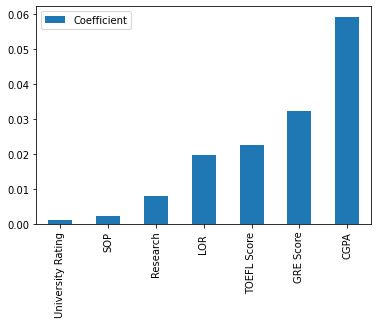

In [186]:
coeffs.plot.bar()

In [187]:
filename = 'C:/git/gradpredictor/models/pls_model.sav'
pickle.dump(pls_2, open(filename, 'wb'))

In [188]:
sop=5
research=1
lor=5
toefl=100
gre=310
gpa=9

new_X = np.array([gre, toefl, 5, sop, lor, gpa, research])
prediction = pls_2.predict(new_X.reshape(1,-1))
print(prediction)


[[0.76318788]]


### Non-linear models don't fare better 

In [47]:
rfr = RandomForestRegressor()
gbr = GradientBoostingRegressor()
rfr.fit(X_train.values, y_train.values)
gbr.fit(X_train.values, y_train.values)
print(f"RF r-squared {rfr.score(X_test.values, y_test.values):.3f}")
print(f"GB r-squared {gbr.score(X_test.values, y_test.values):.3f}")

RF r-squared 0.794
GB r-squared 0.782


In [107]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train.values, y_train.values)
print(f"KNN r-squared {knn.score(X_test.values, y_test.values):.3f}")

KNN r-squared 0.725


# Creating 5 models, one for each Uni. Tier

In [72]:
df_1 = df[df['University Rating']==1]
df_2 = df[df['University Rating']==2]
df_3 = df[df['University Rating']==3]
df_4 = df[df['University Rating']==4]
df_5 = df[df['University Rating']==5]

In [73]:
X_1 = df_1.drop(['Chance of Admit ','University Rating'], axis=1)
Y_1 = df_1['Chance of Admit ']
X_2 = df_2.drop(['Chance of Admit ','University Rating'], axis=1)
Y_2 = df_2['Chance of Admit ']
X_3 = df_3.drop(['Chance of Admit ','University Rating'], axis=1)
Y_3 = df_3['Chance of Admit ']
X_4 = df_4.drop(['Chance of Admit ','University Rating'], axis=1)
Y_4 = df_4['Chance of Admit ']
X_5 = df_5.drop(['Chance of Admit ','University Rating'], axis=1)
Y_5 = df_5['Chance of Admit ']


### For Tier 5 Unis, the features are not relevant

<AxesSubplot:>

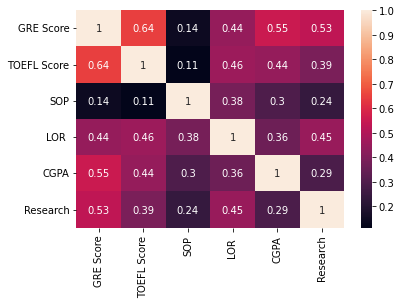

In [36]:
sns.heatmap (X_1.corr(), annot=True)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_1, Y_1,test_size = 0.2, random_state=42)
n = 3
pcr_2 = make_pipeline(StandardScaler(),PCA(n_components=n), LinearRegression())
pcr_2.fit(X_train.values, y_train.values)
pls_2 = PLSRegression(n_components=n)
pls_2.fit(X_train.values, y_train.values)
print(f"PCR r-squared with {n} components {pcr_2.score(X_test.values, y_test.values):.3f}")
print(f"PLS r-squared with {n} components {pls_2.score(X_test.values, y_test.values):.3f}")

PCR r-squared with 3 components -0.235
PLS r-squared with 3 components -0.758


In [116]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train.values, y_train.values)
print(f"KNN r-squared {knn.score(X_test.values, y_test.values):.3f}")

KNN r-squared 0.367


### For Tier 4 Unis, the model looks better, but still poor 

<AxesSubplot:>

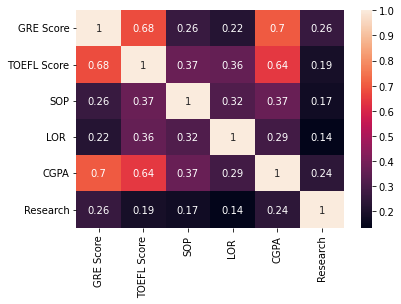

In [50]:
sns.heatmap (X_2.corr(), annot=True)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X_2, Y_2,test_size = 0.2, random_state=42)
n = 3
pcr_2 = make_pipeline(StandardScaler(),PCA(n_components=n), LinearRegression())
pcr_2.fit(X_train.values, y_train.values)
pls_2 = PLSRegression(n_components=n)
pls_2.fit(X_train.values, y_train.values)
print(f"PCR r-squared with {n} components {pcr_2.score(X_test.values, y_test.values):.3f}")
print(f"PLS r-squared with {n} components {pls_2.score(X_test.values, y_test.values):.3f}")

PCR r-squared with 3 components 0.421
PLS r-squared with 3 components 0.479


In [118]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train.values, y_train.values)
print(f"KNN r-squared {knn.score(X_test.values, y_test.values):.3f}")

KNN r-squared 0.153


### Tier 3 Unis

<AxesSubplot:>

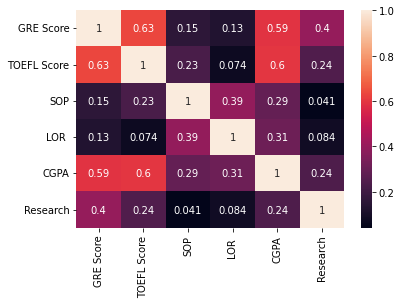

In [56]:
sns.heatmap (X_3.corr(), annot=True)

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_3, Y_3,test_size = 0.2, random_state=42)
n = 3
pcr_2 = make_pipeline(StandardScaler(),PCA(n_components=n), LinearRegression())
pcr_2.fit(X_train.values, y_train.values)
pls_2 = PLSRegression(n_components=n)
pls_2.fit(X_train.values, y_train.values)
print(f"PCR r-squared with {n} components {pcr_2.score(X_test.values, y_test.values):.3f}")
print(f"PLS r-squared with {n} components {pls_2.score(X_test.values, y_test.values):.3f}")

PCR r-squared with 3 components 0.627
PLS r-squared with 3 components 0.657


In [127]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train.values, y_train.values)
print(f"KNN r-squared {knn.score(X_test.values, y_test.values):.3f}")

KNN r-squared 0.306


### Tier 2 Unis: looking decent

<AxesSubplot:>

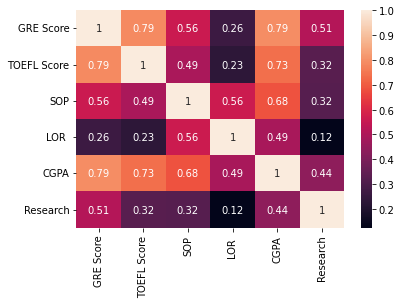

In [59]:
sns.heatmap (X_4.corr(), annot=True)

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X_4, Y_4,test_size = 0.2, random_state=42)
n = 3
pcr_2 = make_pipeline(StandardScaler(),PCA(n_components=n), LinearRegression())
pcr_2.fit(X_train.values, y_train.values)
pls_2 = PLSRegression(n_components=n)
pls_2.fit(X_train.values, y_train.values)
print(f"PCR r-squared with {n} components {pcr_2.score(X_test.values, y_test.values):.3f}")
print(f"PLS r-squared with {n} components {pls_2.score(X_test.values, y_test.values):.3f}")

PCR r-squared with 3 components 0.714
PLS r-squared with 3 components 0.702


In [130]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train.values, y_train.values)
print(f"KNN r-squared {knn.score(X_test.values, y_test.values):.3f}")

KNN r-squared 0.530


### Tier 1 Unis are the most predictable

<AxesSubplot:>

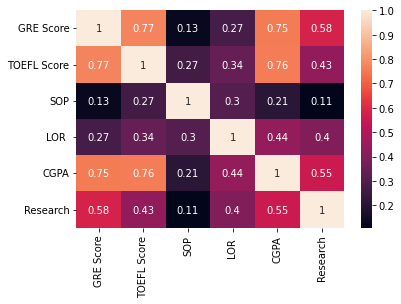

In [74]:
sns.heatmap (X_5.corr(), annot=True)

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X_5, Y_5,test_size = 0.2, random_state=42)
n = 3
pcr_2 = make_pipeline(StandardScaler(),PCA(n_components=n), LinearRegression())
pcr_2.fit(X_train.values, y_train.values)
pls_2 = PLSRegression(n_components=n)
pls_2.fit(X_train.values, y_train.values)
print(f"PCR r-squared with {n} components {pcr_2.score(X_test.values, y_test.values):.3f}")
print(f"PLS r-squared with {n} components {pls_2.score(X_test.values, y_test.values):.3f}")

PCR r-squared with 3 components 0.913
PLS r-squared with 3 components 0.934


In [145]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train.values, y_train.values)
print(f"KNN r-squared {knn.score(X_test.values, y_test.values):.3f}")

KNN r-squared 0.636


### the 'University Rating" doesn't make sense as a feature + self censorship is blatant

In [171]:
X_by_rating = X.groupby(['University Rating']).mean()
X_by_rating

,GRE Score,TOEFL Score,SOP,LOR,CGPA,Research
University Rating,,,,,,
1,304.911765,100.205882,1.941176,2.426471,7.798529,0.294118
2,309.134921,103.444444,2.682540,2.956349,8.177778,0.293651
3,315.030864,106.314815,3.308642,3.401235,8.500123,0.537037
4,323.304762,110.961905,4.000000,3.947619,8.936667,0.780952
5,327.890411,113.438356,4.479452,4.404110,9.278082,0.876712


### New idea: use KNN or L2 norm to predict self-censorship 

In [211]:
X_tier = X.drop(['University Rating'], axis=1)
Y_tier = X['University Rating']

X_train, X_test, y_train, y_test = train_test_split(X_tier, Y_tier,test_size = 0.2, random_state=42)

In [245]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train.values, y_train.values)
gnb = GaussianNB()
gnb.fit(X_train.values, y_train.values)
print(f"KNN accuracy {knn.score(X_test.values, y_test.values):.3f}")
print(f"Naive Bayes accuracy {gnb.score(X_test.values, y_test.values):.3f}")

KNN accuracy 0.590
Naive Bayes accuracy 0.480


In [244]:
sop=3.5
research=0.5
lor=3.5
toefl=106
gre=315
gpa=8.5

new_X = np.array([gre, toefl, sop, lor, gpa, research])
print(int(knn.predict([new_X])))

2


In [234]:
print(norm(X_by_Rating.iloc[2].values-new_X))

0.3844544548598763


In [246]:
filename = 'C:/git/gradpredictor/models/class_model.sav'
pickle.dump(gnb, open(filename, 'wb'))